In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

In [2]:
datadir = '../data/repeatmasker-out'
species_data = {'Danio_rerio': f'{datadir}/fDreABz2.toplevel_curated.20190410.fa.align.parseRM.all-repeats.tab',
                'Danio_aesculapi': f'{datadir}/fDanAes4.curated_primary.20190724.fa.align.parseRM.all-repeats.tab',
                'Danio_kyathit': f'{datadir}/fDanKya3.curated_primary.20190802.fa.align.parseRM.all-repeats.tab',
                'Danio_choprai': f'{datadir}/fDanCho1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
                'Danio_tinwini': f'{datadir}/fDanTin1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
                'Danio_jaintianensis': f'{datadir}/fDanJai1.curated_primary.20190227.fa.align.parseRM.all-repeats.tab',
                'Danio_albolineatus': f'{datadir}/fDanAlb1.curated_primary.20190208.fa.align.parseRM.all-repeats.tab',
                'Danionella_dracula': f'{datadir}/fDanDra1.1.fa.align.parseRM.all-repeats.tab',
                'Danionella_translucida': f'{datadir}/fDanTra1.curated_assembly.fa.align.parseRM.all-repeats.tab',
               }

In [3]:
def read_parserm(filename):
    """Return dataframe containing parsed RepeatMasker output."""
    parserm_df = pd.read_csv(filename, 
                             sep='\t')
    glen, nonrep = calc_genome_length(parserm_df)
    parserm_df = parserm_df.append(pd.DataFrame({'Rclass': ['Genome'], 'LEN_MASKED_NR': [nonrep]}))
    parserm_df = parserm_df.loc[parserm_df.Rclass.isin(['LTR', 'LINE', 'DNA', 'SINE', 'RC', 'Unknown', 'Genome'])]
    return parserm_df

def calc_genome_length(df):
    """This calculates the size of the genome and the number of unmasked bases."""
    glen = df['LEN_MASKED_NR'].sum()/(df['%_GENOME'].sum())
    nonrep = glen - df['LEN_MASKED_NR'].sum()
    return glen, nonrep

def count_finz(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

In [4]:
finz_df = []
for species, filename in species_data.items():
    df = read_parserm(filename)
    df = df.groupby('Rclass')[['%_GENOME', 'LEN_MASKED_NR']].sum().reset_index()
    df['species'] = species
    df['finz'] = count_finz(species)
    finz_df.append(df)

# Manually add species
finz_df.append(pd.DataFrame([
 ['DNA', 0.1638, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['LTR', 0.0489, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['LINE', 0.045, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['SINE', 0.0047, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['RC', 0.0189, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['Unknown', 0.0688, 'Carassius_auratus', count_finz('Carassius_auratus')],
 ['DNA', 0.1753, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')],
 ['LTR', 0.0435, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')],
 ['LINE', 0.049, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')],
 ['SINE', 0.0047, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')],
 ['RC', np.nan, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')],
 ['Unknown', np.nan, 'Cyprinus_carpio', count_finz('Cyprinus_carpio')]
], columns=['Rclass', '%_GENOME', 'species', 'finz']))

finz_df = pd.concat(finz_df)
print(finz_df)

     Rclass  %_GENOME  LEN_MASKED_NR          species  finz
0       DNA  0.350682    434661971.0      Danio_rerio   816
1    Genome  0.000000    636635314.0      Danio_rerio   816
2      LINE  0.028717     35594347.0      Danio_rerio   816
3       LTR  0.050314     62362653.0      Danio_rerio   816
4        RC  0.020211     25050695.0      Danio_rerio   816
..      ...       ...            ...              ...   ...
7       LTR  0.043500            NaN  Cyprinus_carpio   187
8      LINE  0.049000            NaN  Cyprinus_carpio   187
9      SINE  0.004700            NaN  Cyprinus_carpio   187
10       RC       NaN            NaN  Cyprinus_carpio   187
11  Unknown       NaN            NaN  Cyprinus_carpio   187

[75 rows x 5 columns]


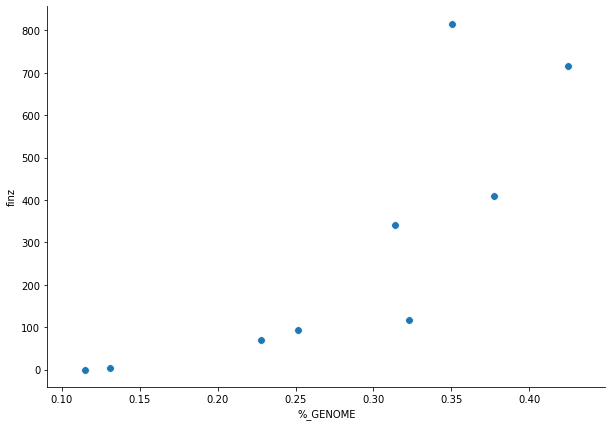

SpearmanrResult(correlation=0.9333333333333332, pvalue=0.00023589981215941676)


In [9]:
teclass = 'DNA'
tmp_df = finz_df.loc[(finz_df.Rclass == teclass) & ~finz_df['LEN_MASKED_NR'].isna()]
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=tmp_df, 
                x='%_GENOME', 
                y='finz',
                s=60,
                ax=ax)

# for row in finz_df.loc[finz_df.Rclass == teclass].iterrows():
#     ax.text(row[1]['%_GENOME']+0.005, row[1]['finz']+np.random.randint(-10, 10), row[1]['species'])

sns.despine()
plt.show()
print(stats.spearmanr(tmp_df['%_GENOME'], 
                      tmp_df['finz']))

SpearmanrResult(correlation=0.6363636363636364, pvalue=0.03528698122006226)


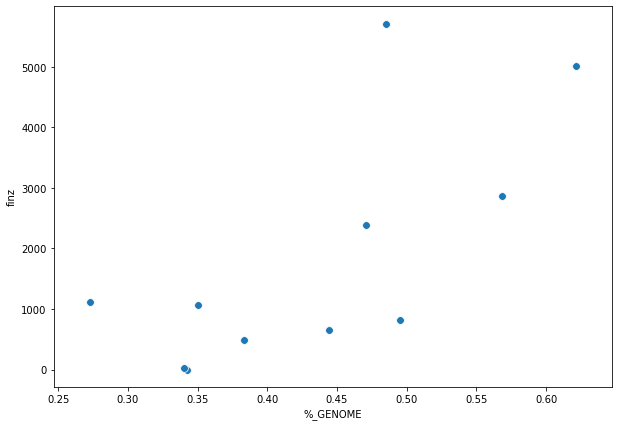

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=finz_df.groupby('species').sum().reset_index(), 
                x='%_GENOME', 
                y='finz',
                s=60,
                ax=ax)
print(stats.spearmanr(finz_df.groupby('species').sum().reset_index()['%_GENOME'], 
                      finz_df.groupby('species').sum().reset_index()['finz']))

In [27]:
print(finz_df)

     Rclass  %_GENOME          species  finz
0       DNA  0.350682      Danio_rerio   154
1    Genome  0.000000      Danio_rerio   154
2      LINE  0.028717      Danio_rerio   154
3       LTR  0.050314      Danio_rerio   154
4        RC  0.020211      Danio_rerio   154
..      ...       ...              ...   ...
7       LTR  0.043500  Cyprinus_carpio     5
8      LINE  0.049000  Cyprinus_carpio     5
9      SINE  0.004700  Cyprinus_carpio     5
10       RC       NaN  Cyprinus_carpio     5
11  Unknown       NaN  Cyprinus_carpio     5

[75 rows x 4 columns]
